<a href="https://colab.research.google.com/github/kwanda2426/projects/blob/main/Sebokeng_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [8]:
!pip install pandas openpyxl


In [9]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
#
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
import missingno as msno

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


# **Importing Data**

In [10]:
# Reading data
url = "https://raw.githubusercontent.com/kwanda2426/projects/main/sebokeng_data.xlsx"
df = pd.read_excel(url, engine='openpyxl')


In [11]:
# Showing first 5 lines of data
df.head()


,sebSO2,sebNO2,sebO3,sebPM25,sebPM10
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


# **Data Preprocessing**

In this section, we transform raw data to well-formed data sets so that data analytics can be applied. Raw data is often incomplete and has inconsistent formatting. We do both data validation and data imputation.The goal of data imputation is to correct errors and input missing values. We were told of the time-series nature of our data set, but in this data the timestamp is missing, we therefore have to create that using the knowledge that the data is from January 2011 to February 2020.

The main goal is to ensure that the data in question is both complete and accurate.

In [12]:
# changing column names
df['SO2'] = df['sebSO2']
df['NO2'] = df['sebNO2']
df['O3'] = df['sebO3']
df['PM25'] = df['sebPM25']
df['PM10'] = df['sebPM10']

In [19]:
#Adding date column
new_date = pd.date_range(start='2011-01-01', end='2020-02-27', freq='D')
df['Date'] = new_date

#final dataframe
df.set_index('Date', inplace=True)
df_final = df
df_final = df_final[['SO2', 'NO2', 'O3',
       'PM25', 'PM10']]

In [20]:
df_final.head()

,SO2,NO2,O3,PM25,PM10
Date,,,,,
2011-01-01,NaN,NaN,NaN,NaN,NaN
2011-01-02,NaN,NaN,NaN,NaN,NaN
2011-01-03,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,NaN,NaN,NaN,NaN


In [21]:
df_final.columns

Index(['SO2', 'NO2', 'O3', 'PM25', 'PM10'], dtype='object')

In [22]:
# Rows and Columns of data
print('Data has {} rows and {} Columns'.format(df_final.shape[0],df_final.shape[1]))
print('')
print('Data has the following columns:')
for i in df_final.columns:
  print(i)

Data has 3345 rows and 5 Columns

Data has the following columns:
SO2
NO2
O3
PM25
PM10


### Data Type of Columns

In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3345 entries, 2011-01-01 to 2020-02-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SO2     1925 non-null   float64
 1   NO2     2055 non-null   float64
 2   O3      2371 non-null   float64
 3   PM25    1853 non-null   float64
 4   PM10    1827 non-null   float64
dtypes: float64(5)
memory usage: 156.8 KB


We can see that all our columns have the same data type which is numeric. We can see that non-null rows for each column is not the same as total rows, this means that our data has some missing entries.

### Checking for missing Data

<Figure size 800x400 with 0 Axes>

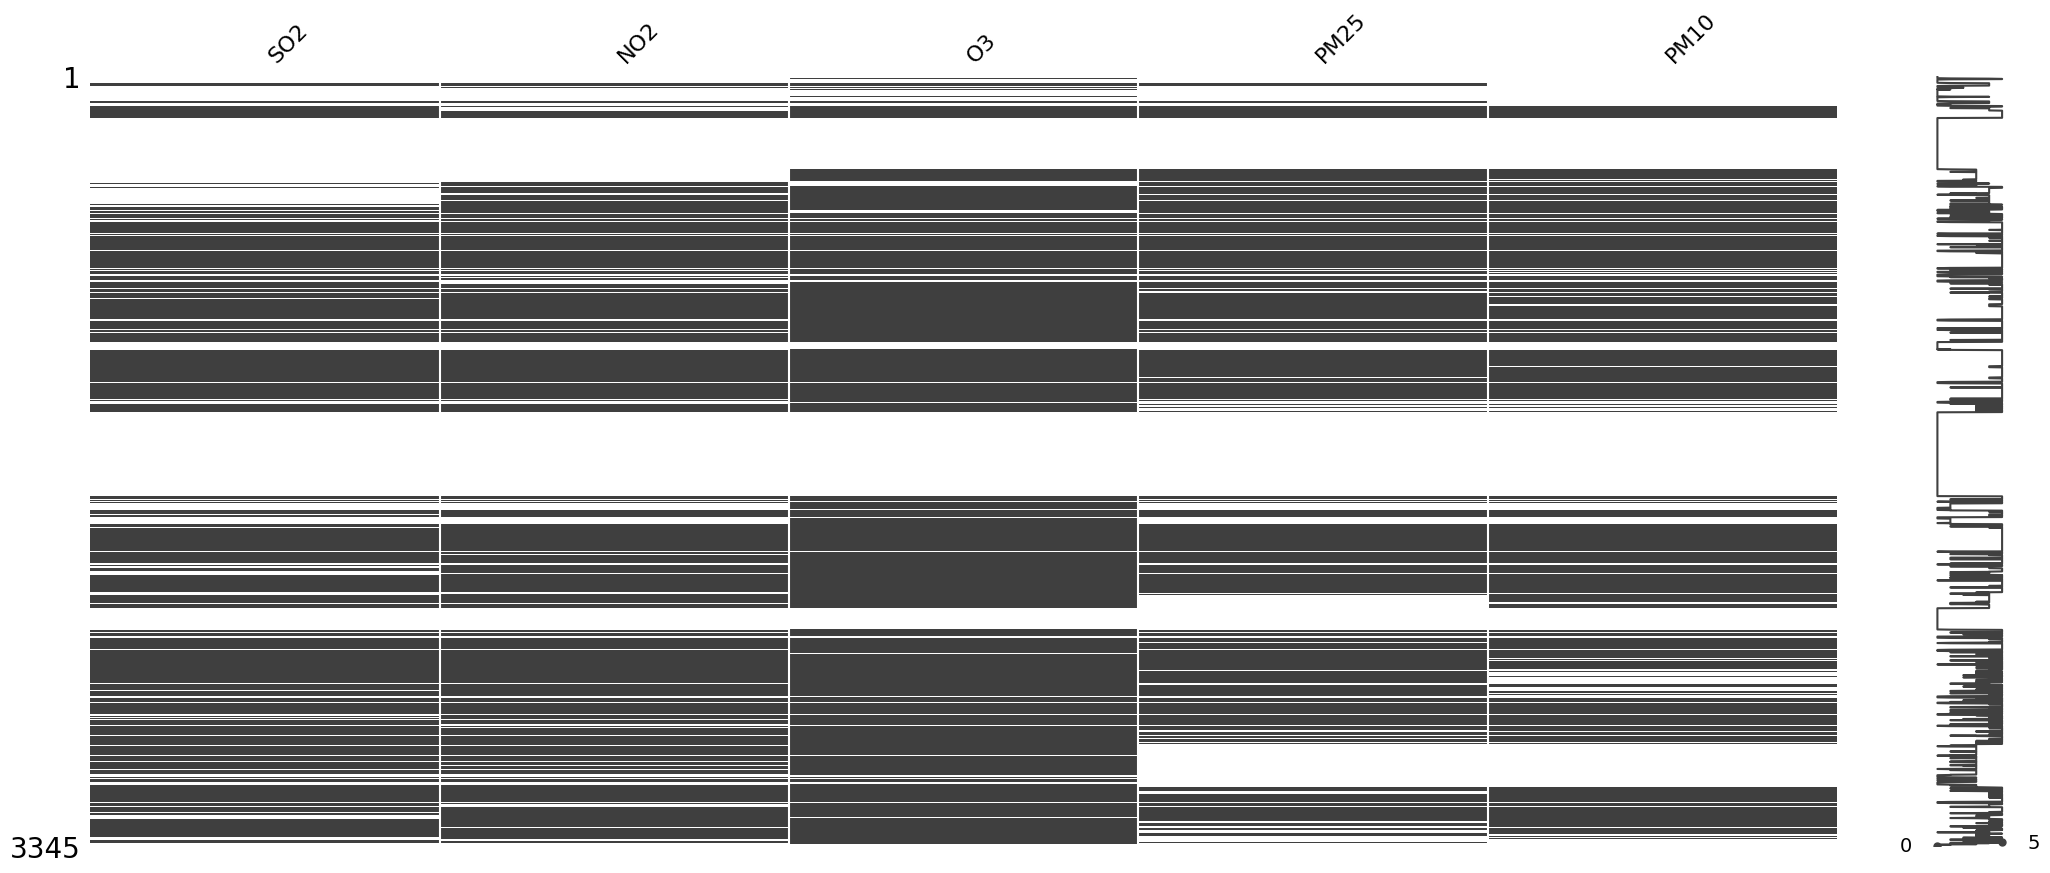

In [24]:
# Missing entries distribution
plt.figure(figsize=(8, 4))  # Width x Height in inches
msno.matrix(df_final)
plt.show()




<Axes: >

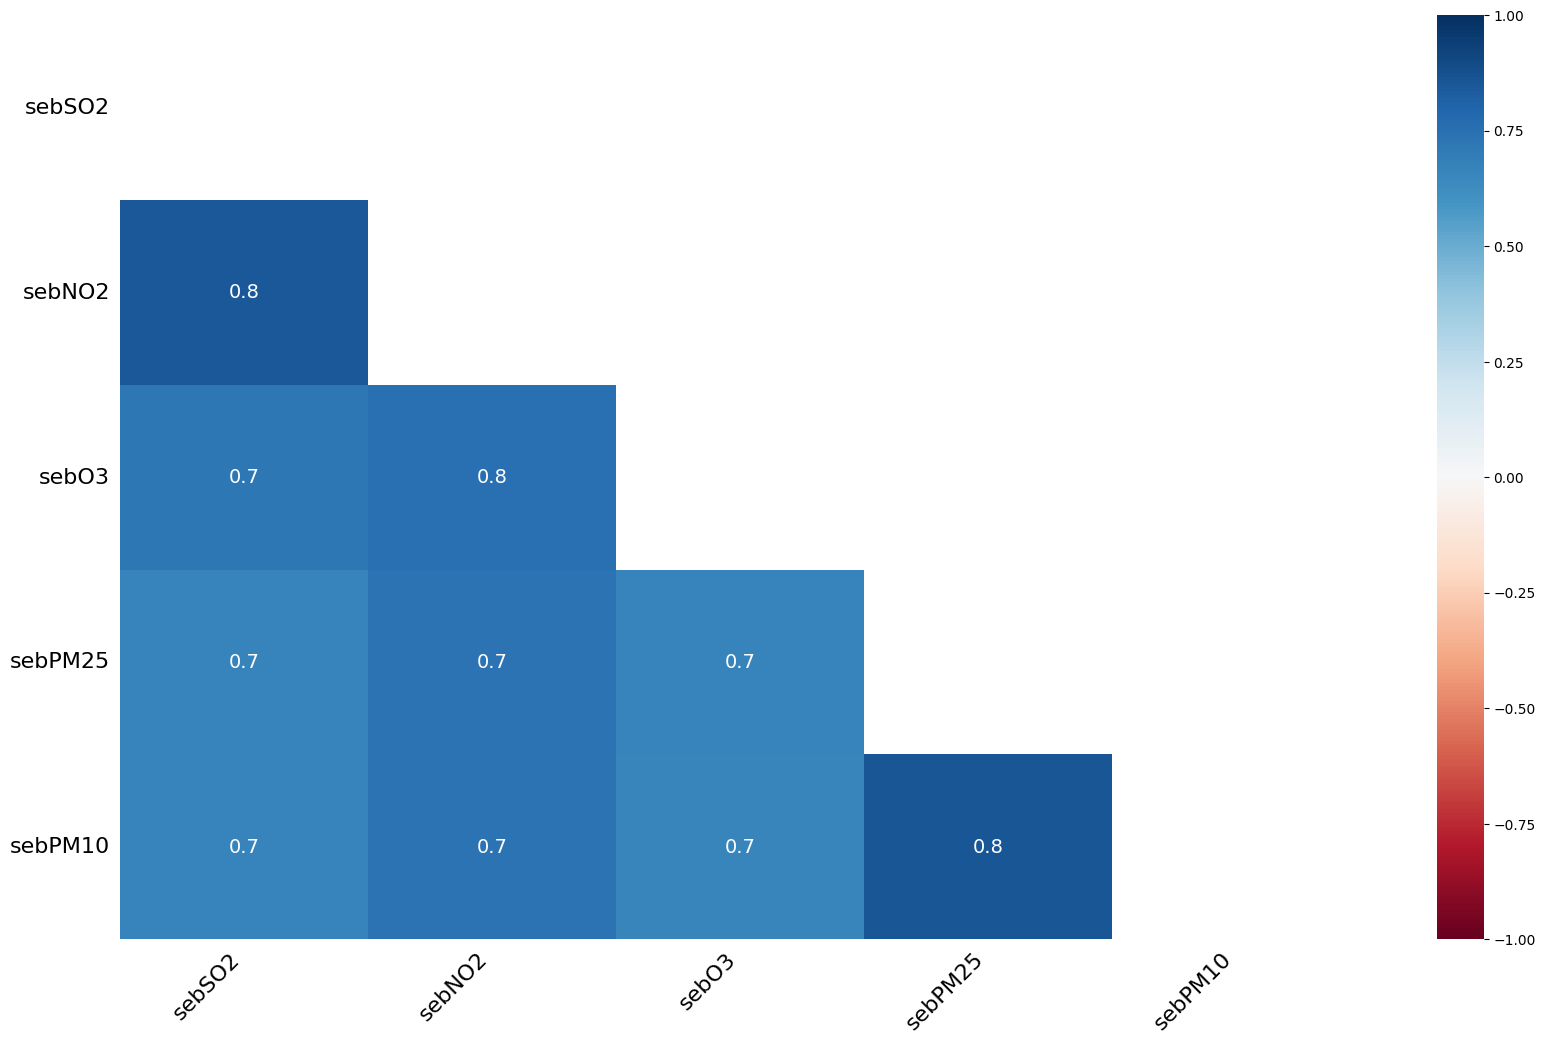

In [ ]:
msno.heatmap(df_final)


**Note:**+1 *means a strong correlation*.

There is no correlation that is less than 0.5.We can see that this missingness is highly and positively correlated, multivariate imputation is more appropriate.

In [ ]:
# Quantifying missing entries
cols = df_final.columns
rows = [int(df_final.isnull().sum()[i]) for i in range(0,len(df_final.columns))]
perc = [str(round(100*int(df_final.isnull().sum()[i])/df_final.shape[0],2))+'%' for i in range(0,len(df_final.columns))]


final_list = list(zip(cols,rows,perc))

# Create DataFrame from the zipped list with column names
missing_entries = pd.DataFrame(final_list, columns=['Column Name', 'Number of missing entries','% missing entries'])
missing_entries

,Column Name,Number of missing entries,% missing entries
0,sebSO2,1420,42.45%
1,sebNO2,1290,38.57%
2,sebO3,974,29.12%
3,sebPM25,1492,44.6%
4,sebPM10,1518,45.38%


We can see that our data is multivariate and all columns have missing entries  greater than 20% and we cannot drop them, otherwise we will have no data. Hence to avoid risk of bias, consider advanced imputation.